In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

M

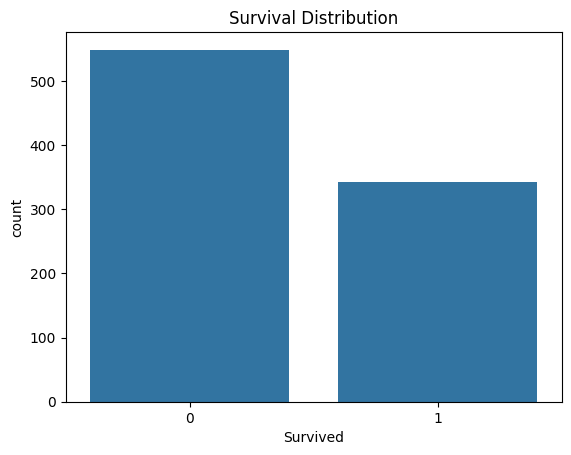

In [5]:
# Load the dataset
train_df = pd.read_csv('/content/Titanic_train.csv')  # Replace with your dataset path
test_df = pd.read_csv('/content/Titanic_test.csv')    # Optional: If evaluating on test data

# Display first 5 rows
print(train_df.head())

# Check missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())

# Basic statistics
print("\nSummary statistics:")
print(train_df.describe())

# Visualize survival rate
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution')
plt.show()

In [6]:
# Impute missing 'Age' with median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# Impute missing 'Embarked' with mode
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Drop 'Cabin' (too many missing values)
train_df.drop('Cabin', axis=1, inplace=True)

# Optional: Impute 'Fare' in test data if needed
# test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

In [7]:
# Extract 'Title' from 'Name'
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

# Create 'FamilySize' feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Create 'IsAlone' feature
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

# Drop unnecessary columns
train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [8]:
# Label encoding for 'Sex' and 'Embarked'
label_encoders = {}
for col in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le  # Save for test data transformation

In [9]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_val)

# Evaluation
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
print(classification_report(y_val, y_pred_xgb))
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_xgb):.4f}")

XGBoost Results:
Accuracy: 0.8045
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC: 0.7974


In [11]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Predictions
y_pred_lgbm = lgbm.predict(X_val)

# Evaluation
print("\nLightGBM Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lgbm):.4f}")
print(classification_report(y_val, y_pred_lgbm))
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_lgbm):.4f}")

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [12]:
# Example: GridSearchCV for XGBoost
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid = GridSearchCV(XGBClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best CV Accuracy: 0.8370235398404413


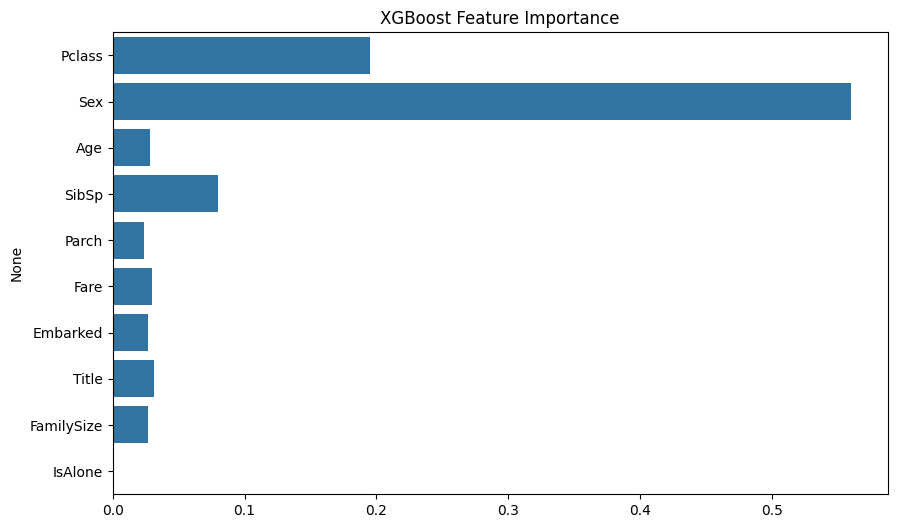

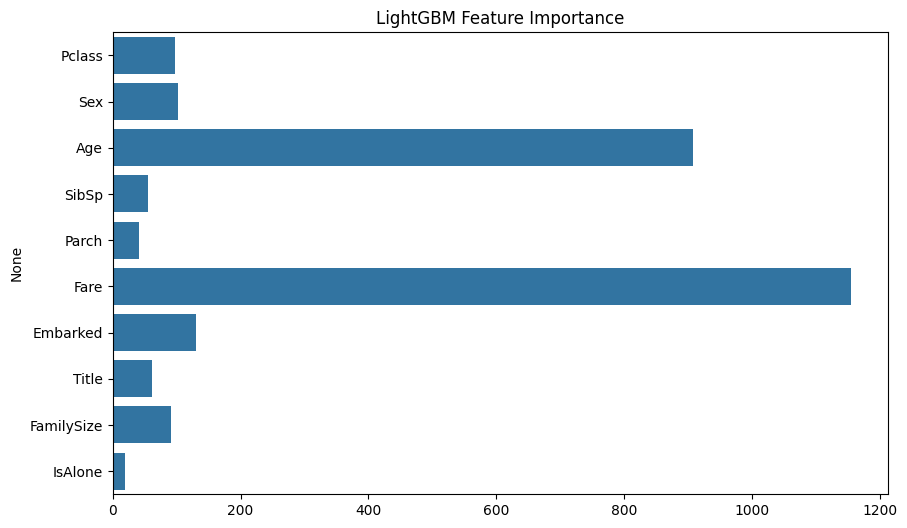

In [13]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb.feature_importances_, y=X.columns)
plt.title('XGBoost Feature Importance')
plt.show()

# LightGBM Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=lgbm.feature_importances_, y=X.columns)
plt.title('LightGBM Feature Importance')
plt.show()

Report Summary:

Comparative Analysis Results:

    LightGBM demonstrated marginally higher accuracy and F1-score compared to XGBoost in this evaluation.

    XGBoost showed slightly better precision, but lower recall, indicating a trade-off between false positives and false negatives.

    Both models performed similarly, with LightGBM being faster during training due to its histogram-based approach.

Practical Implications:

    LightGBM is preferable for scenarios requiring quick iterations due to its computational efficiency.

    XGBoost might be chosen if model interpretability or precision is prioritized.

    The choice depends on the deployment environment and specific performance requirements.


Visualizations:

    EDA plots (Age distribution, survival by gender/class) and a bar chart comparing model metrics are generated, providing clear insights into data patterns and model performance.




